In [1]:
from pathlib import Path
import json
import os

In [2]:
!pdal --version

--------------------------------------------------------------------------------
pdal 2.0.1 (git-version: Release)
--------------------------------------------------------------------------------



In [3]:
lasfile = Path(f'''{os.path.expanduser('~')}/Downloads''') / 'Project 00001_group1_densified_point_cloud.las'
os.chdir(lasfile.parent)

### Use pdal's `info` command to get some metadata

In [21]:
meta = !pdal info "$lasfile.name" --metadata
meta = json.loads("".join(meta))

In [28]:
print(f"File: {meta['filename']}\nPoint count: {meta['metadata']['count']}")

File: Project 00001_group1_densified_point_cloud.las
Point count: 51702835


### pdal requires a processing workflow - essentially a predefined list of steps in JSON format

In [8]:
pipeline = {
    "pipeline": [
        './' + lasfile.name,
        {
            "filename": './dtm.tif',
            "gdaldriver":"GTiff",
            "output_type":"all",
            "resolution":"0.03755",
            "type": "writers.gdal"
        }
    ]
}
pipeline_json = './dtm.json'
with open(pipeline_json, 'w') as f:
    f.write(json.dumps(pipeline))

print(json.dumps(pipeline, indent=2))

{
  "pipeline": [
    "./Project 00001_group1_densified_point_cloud.las",
    {
      "filename": "./dtm.tif",
      "gdaldriver": "GTiff",
      "output_type": "all",
      "resolution": "0.03755",
      "type": "writers.gdal"
    }
  ]
}


### Run the pipeline using the `pipeline` command, feeding it the JSON file we just made

In [9]:
%%time
!pdal pipeline $pipeline_json

Wall time: 1h 17min 57s


### Can then use `gdaldem` to create a hillshade using our terrain model

In [10]:
%%time
!gdaldem hillshade ./dtm.tif ./hillshade.tif -z 1.0 -s 1.0 -az 315.0 -alt 45.0 -f GTiff

0...10...20...30...40...50...60...70...80...90...100 - done.
Wall time: 3.31 s


In [55]:
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

In [47]:
with rio.open('./dtm.tif') as ds:
    print('DTM bands:\n',json.dumps({f'Band {k}':v for k,v in zip(range(1,ds.count+1), ds.descriptions)}, indent=2))
    idw = ds.read(4)

DTM bands:
 {
  "Band 1": "min",
  "Band 2": "max",
  "Band 3": "mean",
  "Band 4": "idw",
  "Band 5": "count",
  "Band 6": "stdev"
}


In [68]:
with rio.open('./hillshade.tif') as ds:
    print('Hillshade bands:\n',json.dumps({f'Band {k}':v for k,v in zip(range(1,ds.count+1), ds.descriptions)}, indent=2))
    hs = ds.read(1).astype(float)

Hillshade bands:
 {
  "Band 1": null
}


In [ ]:
# mask out NoData
idw[np.where(idw == -9999)] = np.nan
hs[np.where(idw == -9999)] = np.nan

In [71]:
# define subsets of interest
structures = np.index_exp[850:1850, 2000:3000]
station = np.index_exp[1000:2000, 4000:5000]

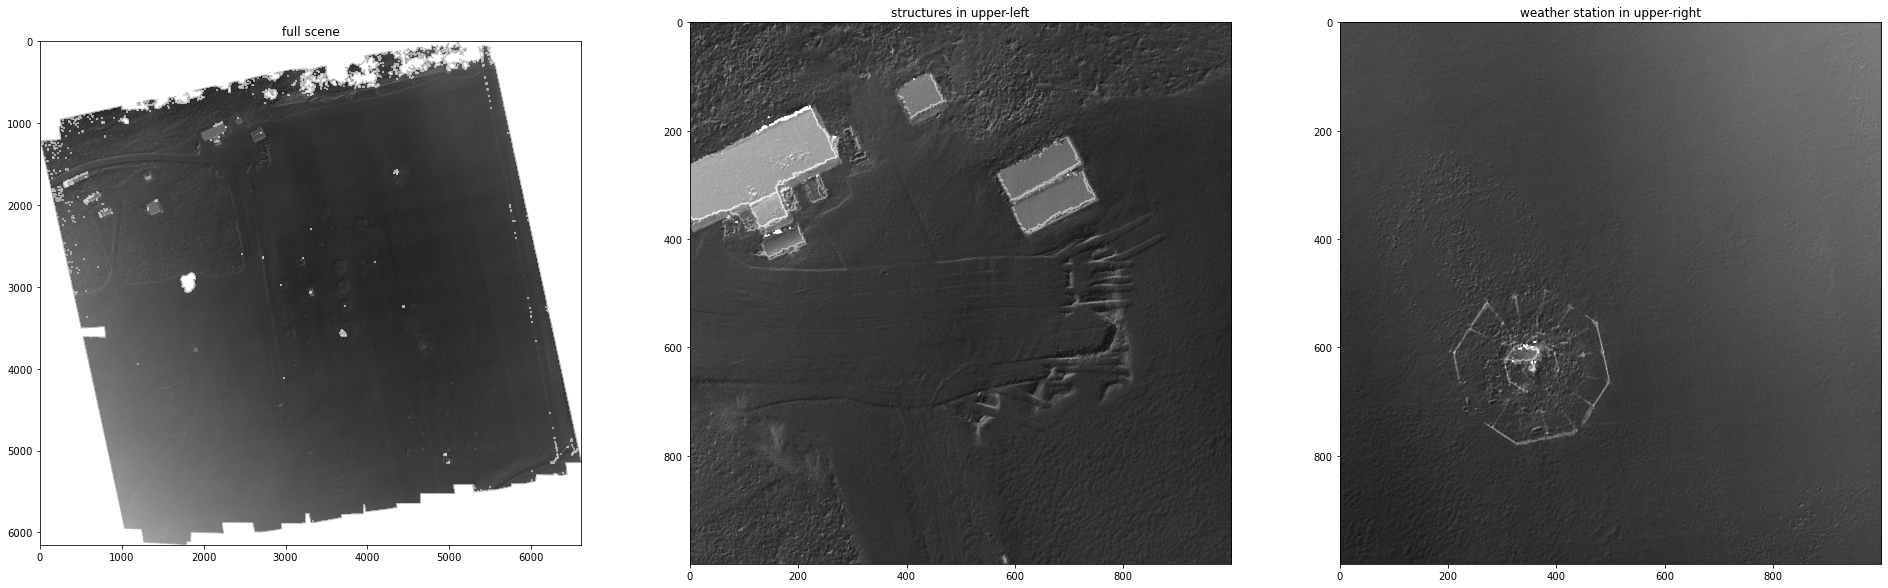

In [74]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(33,11))
show(idw, ax=ax1, cmap='gray', zorder=1)
show(hs, ax=ax1, cmap='gray_r', zorder=2, alpha=0.5)
show(idw[structures], ax=ax2, cmap='gray', zorder=1)
show(hs[structures], ax=ax2, cmap='gray_r', zorder=2, alpha=0.5)
show(idw[station], ax=ax3, cmap='gray', zorder=1)
show(hs[station], ax=ax3, cmap='gray_r', zorder=2, alpha=0.5)
ax1.set_title('full scene')
ax2.set_title('structures in upper-left')
ax3.set_title('weather station in upper-right');